# Preperation

In [1]:
!git clone https://github.com/walkerlab/FENS-2022.git
!pip3 install ./FENS-2022

!wget -nc "https://onedrive.live.com/download?cid=06D44059794C5B46&resid=6D44059794C5B46%21121992&authkey=AHJVfxtvAASasjQ" -O dataset.zip
!unzip -nq 'dataset.zip'

Cloning into 'FENS-2022'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 408 (delta 214), reused 355 (delta 165), pack-reused 0
Receiving objects: 100% (408/408), 4.79 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./FENS-2022
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 56 kB 2.9 MB/s 
  Created wheel for fens: filename=fens-0.1-py3-none-any.whl size=13710 sha256=a1f785

In [2]:
import fens

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# For training
from tqdm import tqdm
from fens.trainers import train_model

# For analyzing
from fens.utility import measures
from scipy.stats import pearsonr

# For CNN definition
from collections import OrderedDict

# For SOTA model
from fens.models import build_lurz2020_model

# Load Dataset

In [3]:
from fens.dataset import load_dataset

dataloaders = load_dataset(path = './Lurz2020/static20457-5-9-preproc0', batch_size=60)
dataset = dataloaders['test'].dataset

# Models

# Training

In [4]:
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439
               }

sota_cnn_model = build_lurz2020_model(**model_config, dataloaders=dataloaders, seed=1234)

state_dict = torch.load("./FENS-2022/trained_nets/sota_cnn_model_state.pt")
sota_cnn_model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
linear_model_config = dict(model_config) # copy the config
linear_model_config['linear'] = True # set linear to True to make it a LN model!

sota_ln_model = build_lurz2020_model(**linear_model_config, dataloaders=dataloaders, seed=1234)

state_dict = torch.load("./FENS-2022/trained_nets/sota_ln_model_state.pt")
sota_ln_model.load_state_dict(state_dict)

<All keys matched successfully>

# Receptive Field

## Gradient RF

In [ ]:
def generate_grad_rf(model, neuron_idx, input_image, device="cuda"):
    assert input_image.ndim == 2
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device=device,
        requires_grad=True,
    )
    # be sure to put the model on eval mode
    model.eval()
    model.to(device)
    # get the response of the target neuron
    model_activation = model(x)[:, neuron_idx]
    # compute gradient with respect to the input
    model_activation.backward()
    
    # prepare the gradient RF
    grad_rf = x.grad.data.cpu().numpy().squeeze()
    return grad_rf

## MEI

In [6]:
def generate_mei(
    model,
    input_image,
    neuron_idx,
    iterations,
    mean_constr,
    std_constr,
    lr=1,
    device="cuda",
    disable_progress_bar=False,
):
    assert input_image.ndim == 2
    std_constr = torch.tensor(std_constr).to(device)
    mean_constr = torch.tensor(mean_constr).to(device)

    # be sure to put the model on eval mode
    model.eval()
    model.to(device)
    
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device=device,
        requires_grad=True,
    )

    optimizer = torch.optim.SGD([x], lr=lr, momentum=0.9)
    model_activations = []
    for i in tqdm(range(iterations), disable=disable_progress_bar):
        # fix the mean and std of the input image
        transformed_x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr  # 1e-4 is added to avoid division by zero
        model_activation = model(transformed_x)[:, neuron_idx]
        (-model_activation).backward()
        model_activations.append(model_activation.detach().cpu().numpy())
        optimizer.step()
    # finally, reapply the mean and norm constrain on the image
    x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr
    return np.array(model_activations), x.detach().cpu().numpy().squeeze()

# Regenerate the input images

把上面对5个神经元的MEI计算推广到所有神经元（5335个，见response的长度），所得结果记录在meis中。（已经计算出meis，则跳过此处）

In [ ]:
# choose input mean as starting point
input_mean = dataset.statistics.images.all.mean
input_std = dataset.statistics.images.all.std

In [ ]:
neuron_idx_ls = range(0,5335)
meis = []
for i in tqdm(neuron_idx_ls):
    _, mei = generate_mei(
            sota_cnn_model,
            input_image=np.random.normal(input_mean, input_std / 10, (36, 64)),
            neuron_idx=i,
            iterations=500,
            mean_constr=input_mean,
            std_constr=input_std / 10,
            disable_progress_bar=True,
    )
    meis.append(mei)
    np.save("./meis/{}.npy".format(i),mei)

meis = torch.tensor(np.stack(meis))[:, None, ...]

 70%|███████   | 3753/5335 [2:38:09<1:06:25,  2.52s/it]

用meis结合response[i]，算出input[i]，与image[i]做对比。

In [7]:
trial_idx = 1
trial_image = np.load(f'./Lurz2020/static20457-5-9-preproc0/data/images/{trial_idx}.npy')
trial_response = np.load(f'./Lurz2020/static20457-5-9-preproc0/data/responses/{trial_idx}.npy')

如果已经计算出meis，则直接载入。

In [8]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/pro")
meis = np.load("meis.npy")

Mounted at /content/drive


In [1]:
trial_image_generated = torch.zeros((1,36,64))
trial_response = np.tile(trial_response[:,np.newaxis,np.newaxis],(1,36,64))
trial_image_generated = trial_response * meis

NameError: ignored

In [14]:
trial_image_generated = trial_image_generated.sum(0)
trial_image_generated = trial_image_generated[np.newaxis,:]
trial_image_generated.shape

(1, 36, 64)

Text(0.5, 1.02, 'Images')

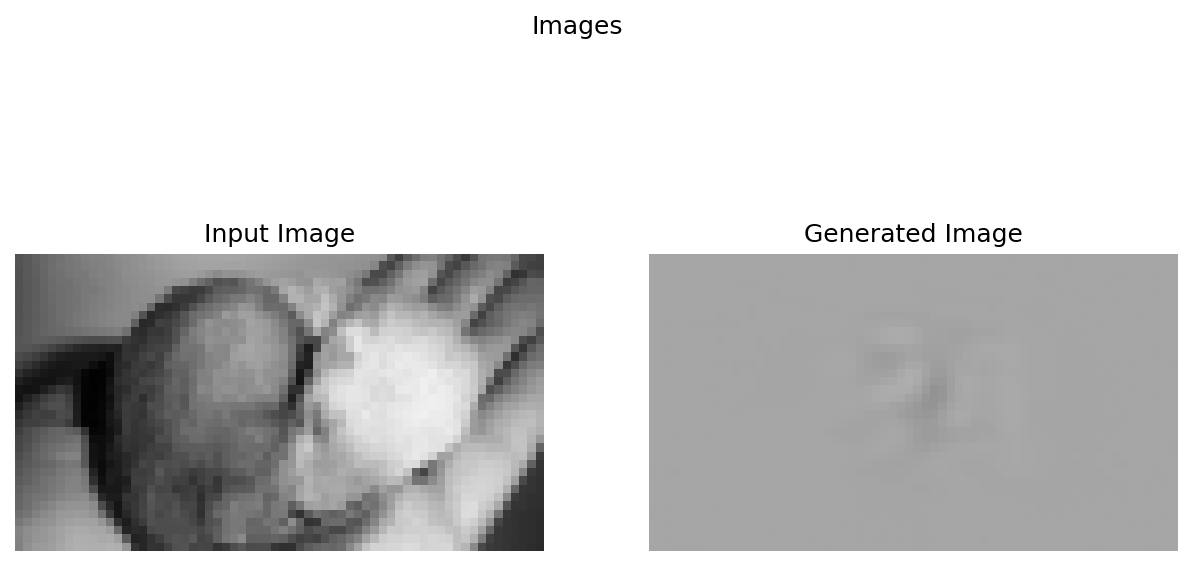

In [15]:
# compare the two meis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)
axes[0].imshow(trial_image.squeeze(), cmap='gray', vmin=0, vmax=255)
axes[0].axis('off')
axes[0].set_title('Input Image')
axes[1].imshow(trial_image_generated.squeeze(), cmap='gray', vmin=0, vmax=255)
axes[1].axis('off')
axes[1].set_title('Generated Image')
plt.suptitle('Images', y=1.02)